# **Diffusion Model in Causal Inference with Unmeasured Confounders**
## **Tatsuhiro Shimizu**
## ***AI Lab, CyberAgent Tokyo, Japan***
## **0009-0009-9746-3346**

This is the code for the Example 12. in the main text.
The following image is the SCM that we implement.

- <font color='red'>Unobserved nodes: $X_2$</font>
- Cause node: $X_4$
- Outcome node: $X_6$
- Node that satisfies the backdoor criterion for a pair $(X_4, X_6)$: $X_3$

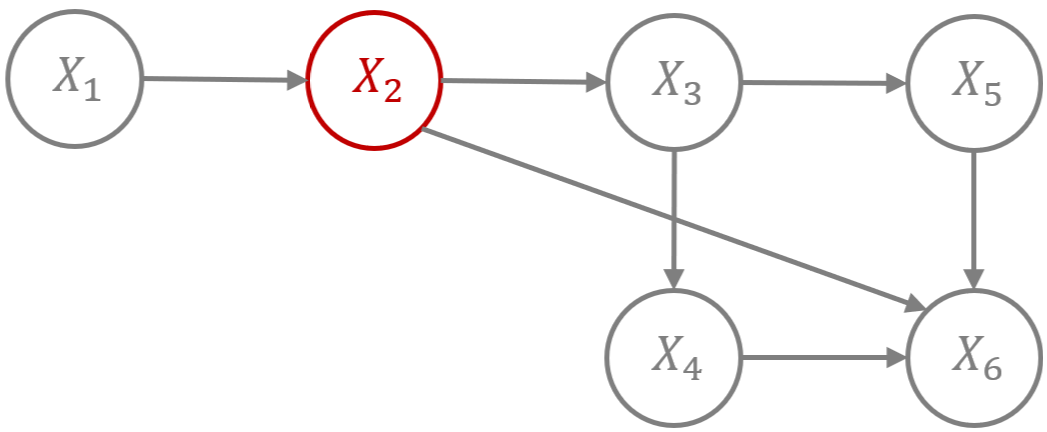

Define
- the number of observation: n_obs = 1000 (same environment as the DCM paper)
- the number of samples from DCM and BDCM: n_sample_DCM = 500 (same environment as the DCM paper)

## DCM Training

Define
- time: $T = 100$
- noise schedule: $\beta_t$ and $\alpha_t$ for all $i = 1, \cdots, T$

- Define
  - the structural equation: $X_i = f(PA(X_i)) + U_i$
    - $X_1 = U_1$
    - $X_2 = X_1^2 + U_2$
    - $X_3 = X_2 + U_3$
    - $X_4 = X_3^2 + X_3 + U_4$
    - $X_5 = X_3^2 + 0.1 + U_5$
    - $X_6 = X_2 X_4 + X_2 X_5 + X_4 X_5 + U_6$
  - number of internvened values
  - intervened values

- Sample
  - exogeneous nodes: $U_1, U_2, U_3, U_4, U_5, U_6 \sim \mathcal{N}(0, 1)$
  - endogenous nodes: $X_1, X_2, X_3, X_4, X_5, X_6$
  - intervened nodes: $X_6|do(X_4 = x_4)$
  - time: $t \sim \mathcal{N}(0, 1)$
  - noise: $\epsilon \sim \mathcal{N}(0, 1)$


  - Define
    - epoch: num_epochs = 500
    - batch size: batch_size = 64
    - learning rate: learning_rate $\eta$ = 0.0001

  - Neural Network: 3 hidden layers
    - 1st layer: 128 nodes
    - 2nd layer: 256 nodes
    - 3rd layer: 256 nodes

  - Train the Neural Network

  - Plot the loss of the training over the epoch

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional
import torch.utils.data

# Warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

plt.style.use('ggplot')

%matplotlib inline

import conf
from func import set_seed, normalize, DEC, create_array_array_MMD, train_and_plot_neural_net, create_alpha_t_train_for_x, save_array, create_input_for_NN, calculate_overall_MMD
# from sample import sample_array_u
from sample import sample_array_u_and_x, true_sample, sample_t_and_eps_for_x

from tqdm import tqdm


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  1.40it/s]

mean of MMD for DCM: 0.00648
standard deviation of MMD for DCM: 0.000404
mean of MMD for BDCM: 0.00534
standard deviation of MMD for BDCM: 0.000157


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

mean of MMD for DCM: 0.0224
standard deviation of MMD for DCM: 0.017
mean of MMD for BDCM: 0.0201
standard deviation of MMD for BDCM: 0.0123


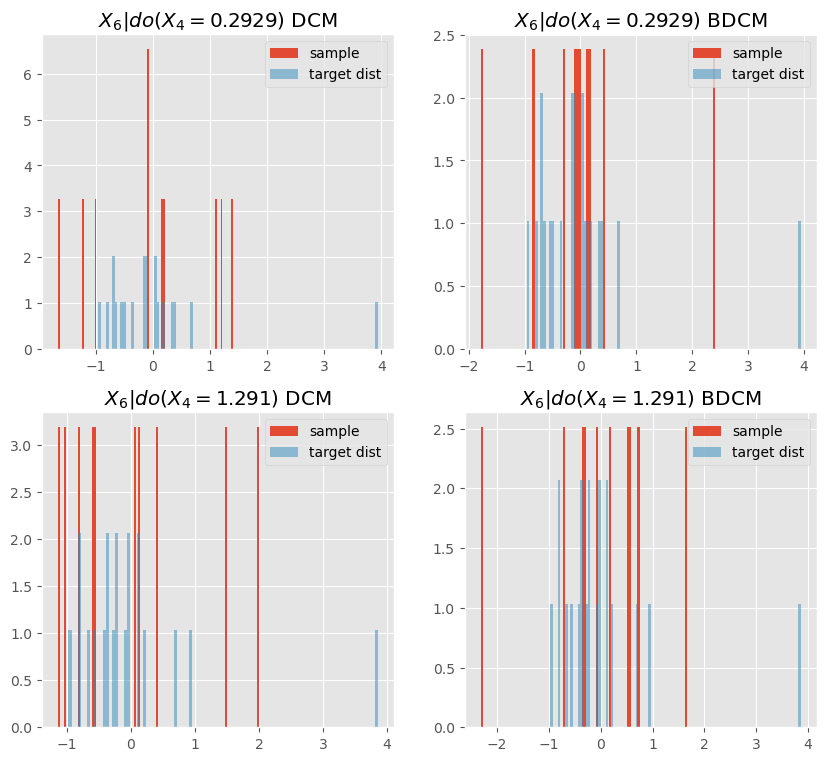

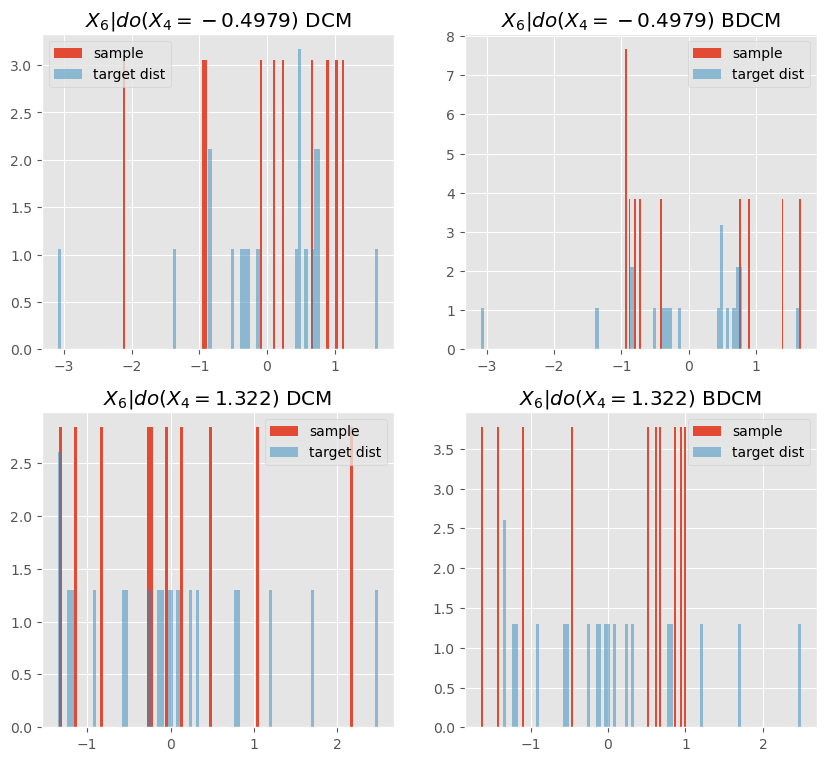

In [2]:
"""# **NEED TO MODIFY HERE**
only d
"""

# Define the number of endogenous or exogenous variables in SCM
d = 6

# index for cause variable X_i = 4
ind_cause = 3

# index for result variable X_i = 6
ind_result = 5

# the array of the list of the indexes of the parent node in DAG
array_list_parent_ind = [[], [1], [2], [3], [3], [2, 4, 5]]

# Define the structual equation
# X_i = f_i(X_{pa_i}) + U_i

def structural_eq(u, ind, x):
  if ind == 0:
    output = u
  elif ind == 1:
    output = x[0] ** 2 + u
  elif ind == 2:
    output = x[1] + u
  elif ind == 3:
    output = x[2] ** 3 + x[2] + u
  elif ind == 4:
    output = x[2] ** 2 + 0.1 + u
  elif ind == 5:
    output = x[1] * x[3] + x[1] * x[4] + x[3] * x[4] + u
  return normalize(output)


# Define the function to sample X_4 n times when we intervene to X_1 in DCM
# Input: the number of samples we want to obtain and the value of the intervention
# Output: the vector of the samples from the target distribution
def sample_outcome_do_cause_DCM(intervened_value, x, array_net_x):
    # Initialize the sample list by just zero vector
    x_outcome_DDIM_list = np.zeros(conf.n_sample_DCM)

    # Iteratively sample from the target distribution
    for i in range(conf.n_sample_DCM):
        # Sample by the empirical distribution
        x1_sampled = random.choice(x[0])
        # Sample by the empirical distribution
        x3_sampled = random.choice(x[2])
        # Set X_4 to the intervened value
        x4_sampled = intervened_value
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x5_parents = np.array([x3_sampled])
        # Sample X_2 by using the decoder function
        x5_sampled = DEC(x5_parents, 0, array_net_x)
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x6_parents = np.array([x4_sampled, x5_sampled])
        # Sample X_2 by using the decoder function
        x6_sampled = DEC(x6_parents, 1, array_net_x)
        # Add the sampled value to the list
        x_outcome_DDIM_list[i] = x6_sampled

    return x_outcome_DDIM_list


# Define the function to sample X_4 n times when we intervene to X_1 in BDCM
# Input: the number of samples we want to obtain and the value of the intervention
# Output: the vector of the samples from the target distribution
def sample_outcome_do_cause_BDCM(intervened_value, x, array_net_x):
    # Initialize the sample list by just zero vector
    x_outcome_DDIM_list = np.zeros(conf.n_sample_DCM)

    # Iteratively sample from the target distribution
    for i in range(conf.n_sample_DCM):
        # Sample by the empirical distribution
        x1_sampled = random.choice(x[0])
        # Sample by the empirical distribution
        x3_sampled = random.choice(x[2])
        # Set X_4 to the intervened value
        x4_sampled = intervened_value
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x5_parents = np.array([x3_sampled])
        # Sample X_2 by using the decoder function
        x5_sampled = DEC(x5_parents, 0, array_net_x)
        # Concatenate the parents and nodes which satisfy the backdoor criterion
        x6_parents = np.array([x3_sampled, x4_sampled])
        # Sample X_2 by using the decoder function
        x6_sampled = DEC(x6_parents, 2, array_net_x)
        # Add the sampled value to the list
        x_outcome_DDIM_list[i] = x6_sampled

    return x_outcome_DDIM_list

# Initialized the array to save the output of each iterations over seeds
array_array_MMD = []
array_title = ["DCM", "BDCM"]

for s in tqdm(range(conf.num_seeds)):
  # Set the seed
  set_seed(s)


  # Define the array of interneved values
  # 10 interventinos with the intervened value ranging from -3 to 3 linearly
  array_interventions = np.random.uniform(conf.lowest_intervention, conf.highest_intervention, conf.num_interventions)

  # # Sample exogenous nodes U_i ~ N(mu, sigma)
  # # Sample endogenous nodes X_i by the structural equations
  array_u, x = sample_array_u_and_x(d, structural_eq)

  # # Generate t ~ Unif([T])
  # # Generate \epsilon ~ N(mu, sigma)
  t_for_x, epsilon_for_x = sample_t_and_eps_for_x(d)

  # # Get the alpha_t for training
  alpha_t_train_for_x = create_alpha_t_train_for_x(d, t_for_x)

  """
  **NEED TO MODIFY HERE**
  """

  # Create the input for the neural network

  # the nodes for which we use DEC
  array_titles = np.array(["X_5", "X_6 (DCM)", "X_6 (BDCM)"])

  # Define the array of the index for epsilon for the neural networks (index - 1)
  array_index_for_epsilon = np.array([4, 5, 5])

  # Define the array of the numbers of the inputs for the neural networks (2 + number of parents or adjustment set)
  array_num_input_for_nn = np.array([3, 4, 4])

  # Define the array of the parents or the adjustment set for each DEC (index - 1)
  parent = [[2], [3, 4], [2, 3]]

  # Create the input for neural network
  array_input_x = create_input_for_NN(array_num_input_for_nn, array_index_for_epsilon, alpha_t_train_for_x, x, epsilon_for_x, parent, t_for_x)


  # """Train the Neural Network"""
  array_net_x = train_and_plot_neural_net(array_input_x, epsilon_for_x, array_index_for_epsilon, array_num_input_for_nn, array_titles, conf.flag_plot_nn_train)

  # # Create the array that save the intervened value, samples from DCM, samples from BDCM
  # Get the samples from DCM and BDCM
  array_array_DCM_BDCM_samples = save_array(array_interventions, sample_outcome_do_cause_DCM, sample_outcome_do_cause_BDCM, x, array_net_x)

  create_array_array_MMD(array_interventions, array_array_DCM_BDCM_samples, true_sample, d, structural_eq, ind_cause, ind_result, array_u, array_array_MMD)

In [3]:
calculate_overall_MMD(array_array_MMD)

mean of all MMD for DCM: 0.0144
standard deviation of all MMD for DCM: 0.0144
mean of all MMD for BDCM: 0.0127
standard deviation of all MMD for BDCM: 0.0114
